In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import dill, os
from astropy.time import Time

In [2]:
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax.config import config
config.update('jax_enable_x64', True)

In [3]:
from jkepler.astrometry import xyzv_from_elements as xyzv

In [4]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='times')
sns.set_palette('colorblind')
plt.rcParams["figure.figsize"] = (18,6)
from matplotlib import rc
rc('text', usetex=True)

In [5]:
year = np.sqrt(4*np.pi**2*1.495978707e11**3/1.32712440018e20)/86400.

In [6]:
datafile = "data/mann19_astrometry.txt"
data = pd.read_csv(datafile, delimiter='|', comment='#')
dates = [data.Date[i]+"T00:00:00" for i in range(len(data))]
times = Time(dates, format='isot', scale='utc').mjd
data['MJD'] = times
odata = pd.read_csv('data/mann19_orbit.txt', delimiter='|', comment='#')
data["Name"] = [n.strip(" ") for n in data.Name]
odata["Name"] = [n.strip(" ") for n in odata.Name]

/Users/k_masuda/miniforge3/envs/jax/lib/python3.10/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 16 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [7]:
targnames = list(odata.Name)

In [8]:
np.array(targnames)

array(['GJ 1005', 'GJ 2005', 'Gl 22', 'Gl 54', 'GJ 1038', 'Gl 65',
       'Gl 84', '2M0213+36', 'Gl 98', 'Gl 99', 'Gl 125', 'Gl 150.2',
       'Gl 190', 'GJ 1081', 'Gl 234', 'LHS 221', 'LHS 224', 'Gl 263',
       'Gl 277', '2M0736+07', 'Gl 301', 'Gl 310', 'Gl 330', 'LHS 6167',
       'Gl 340', 'Gl 352', 'Gl 381', 'Gl 416', 'Gl 469', 'Gl 473',
       'Gl 494', 'Gl 570', 'Gl 600', 'Gl 623', 'GJ 1210', 'Gl 660',
       'Gl 661', 'Gl 667', 'HIP 86707', 'Gl 695', 'Gl 747', 'Gl 748',
       'Gl 762.1', 'Gl 765.2', 'GJ 1245', 'Gl 791.2', 'Gl 804', 'Gl 831',
       'Gl 844', 'HD 239960', 'HIP 111685', 'Gl 893.4', 'Gl 900',
       'LHS 4009', 'Gl 913'], dtype='<U10')

In [9]:
def model(t, sep, e_sep, pa, e_pa, p0, tau0, tdense, emax=0.9, tpred=None):
    medsep = jnp.median(sep)
    lna = numpyro.sample("lna", dist.Uniform(jnp.log(medsep/5), jnp.log(medsep*5)))
    a = numpyro.deterministic("a", jnp.exp(lna))
    cosi = numpyro.sample("cosi", dist.Uniform(-1, 1))
    ecc = numpyro.sample("ecc", dist.Uniform(0, emax))

    cosw = numpyro.sample("cosw", dist.Normal())
    sinw = numpyro.sample("sinw", dist.Normal())
    omega = jnp.arctan2(sinw, cosw)

    cosL = numpyro.sample("cosL", dist.Normal())
    sinL = numpyro.sample("sinL", dist.Normal())
    lnode = jnp.arctan2(sinL, cosL)

    numpyro.deterministic("omega", omega*180./jnp.pi)
    numpyro.deterministic("Omega", lnode*180./jnp.pi)
    numpyro.deterministic("inc", jnp.arccos(cosi)*180./jnp.pi)

    period = numpyro.sample("period", dist.Uniform(p0*0.95, p0*1.05))
    tau = numpyro.sample("tau", dist.Uniform(tau0-0.1*p0, tau0+0.1*p0))
    numpyro.deterministic("T0", tau)
    numpyro.deterministic("pyear", period/year)

    # +x: +Dec, +y: +RA
    x, y, _, _ = xyzv(t, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    xmodel = a * x
    ymodel = a * y
    numpyro.deterministic("x_model", xmodel)
    numpyro.deterministic("y_model", ymodel)

    lnjit = numpyro.sample("lnjit", dist.Uniform(low=-5, high=3))
    jit2 = jnp.exp(lnjit*2)
    numpyro.deterministic("jit", jnp.sqrt(jit2))

    # model on dense time array; just to make a plot look nicer
    xd, yd, _, _ = xyzv(tdense, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
    numpyro.deterministic("xd_model", xd*a)
    numpyro.deterministic("yd_model", yd*a)

    # predicted position at tpred
    if tpred is not None:
        xp, yp, _, _ = xyzv(tpred, period, ecc, jnp.arccos(cosi), omega, lnode, tau)
        xp = numpyro.deterministic("xpred", xp*a)
        yp = numpyro.deterministic("ypred", yp*a)
        numpyro.deterministic("seppred", jnp.sqrt(xp*xp+yp*yp))
        numpyro.deterministic("papred", jnp.arctan2(yp, xp)*180/jnp.pi)

    x = sep * jnp.cos(pa)
    y = sep * jnp.sin(pa)
    x_res = x - xmodel
    y_res = y - ymodel
    sigma2 = jit2 + e_sep**2
    lnsigma2 = jnp.log(sigma2)
    loglikelihood = -0.5*jnp.sum(x_res**2/sigma2 + lnsigma2) - 0.5*jnp.sum(y_res**2/sigma2 + lnsigma2)

    numpyro.factor("loglike", loglikelihood)

In [10]:
def fit_target(name, target_accept_prob=0.95, n_wm=1000, n_sample=1000, overwrite=False, tpred=None):
    didx = data.Name == name
    oidx = odata.Name == name

    if np.sum(didx)==0 and np.sum(oidx)==0:
        print ('no data for %s.'%name)
        return None
    else:
        print ('fitting astrometry of %s...'%name)

    mjd, sep, e_sep, pa, e_pa = np.array(data[didx][["MJD", "Sep", "e_Sep", "PA", "e_PA"]]).T
    pa *= jnp.pi/180.
    e_pa *= jnp.pi/180.

    # for prediction
    tdense = jnp.arange(mjd[0]-50, mjd[-1]+50, 20)

    # initial guess
    p0, tau0 = np.array(odata[oidx][['Per', 'MJD']])[0].T
    p0 = p0 * year

    # output
    basename = "./astrometry_output/" + name

    # run HMC
    if (not os.path.exists(basename+"_mcmc.pkl")) or overwrite:
        kernel = numpyro.infer.NUTS(model, target_accept_prob=target_accept_prob)
        mcmc = numpyro.infer.MCMC(kernel, num_warmup=n_wm, num_samples=n_sample)
        rng_key = random.PRNGKey(0)
        mcmc.run(rng_key, mjd, sep, e_sep, pa, e_pa, p0, tau0, tdense, tpred=tpred, 
                 extra_fields=('potential_energy',))
        mcmc.print_summary()
        #with open(basename+"_mcmc.pkl", "wb") as f:
        #    dill.dump(mcmc, f)
    else:
        with open(basename+"_mcmc.pkl", "rb") as f:
            mcmc = dill.load(f)

    # samples
    s = mcmc.get_samples()

    # for plotting
    xobs, yobs = sep*np.cos(pa), sep*np.sin(pa)
    xmean = jnp.mean(s['x_model'], axis=0)
    ymean = jnp.mean(s['y_model'], axis=0)
    xdmean = jnp.mean(s['xd_model'], axis=0)
    ydmean = jnp.mean(s['yd_model'], axis=0)
    xdstd = jnp.std(s['xd_model'], axis=0)
    ydstd = jnp.std(s['yd_model'], axis=0)
    xyerr = jnp.sqrt(jnp.mean(s['jit'])**2 + e_sep**2)

    # positions in the sky plane
    xymax = max(np.max(np.abs(xobs)), np.max(np.abs(yobs)))*1.1
    plt.figure(figsize=(10,10))
    plt.axes().set_aspect('equal')
    plt.xlim(-xymax, xymax)
    plt.ylim(-xymax, xymax)
    plt.xlabel("$\Delta\mathrm{RA}\cos(\mathrm{Dec})$ $(\mathrm{mas})$")
    plt.ylabel("$\Delta\mathrm{Dec}$ $(\mathrm{mas})$")
    plt.plot([0], [0], '*', color='k', markersize=10)
    plt.plot(yobs, xobs, 'o', label='data', alpha=0.7)
    plt.plot(ymean, xmean, '.', label='mean model')
    #plt.savefig(basename+"_sky.png", dpi=200, bbox_inches="tight")
    #plt.close()

    # astrometry time series
    fig, ax = plt.subplots(2,1,sharex=True)
    ax[0].set_title(name)
    ax[0].errorbar(mjd, xobs, fmt='o', yerr=xyerr)
    ax[0].plot(tdense, xdmean, '-', color='C1')
    ax[0].fill_between(tdense, xdmean-xdstd, xdmean+xdstd, color='C1', alpha=0.2)
    ax[0].set_ylabel("$\Delta\mathrm{RA}\cos(\mathrm{Dec})$ $(\mathrm{mas})$")
    ax[1].set_ylabel("$\Delta\mathrm{Dec}$ $(\mathrm{mas})$")
    ax[1].errorbar(mjd, yobs, fmt='o', yerr=xyerr, color='C0')
    ax[1].plot(tdense, ydmean, '-', color='C1')
    ax[1].fill_between(tdense, ydmean-ydstd, ydmean+ydstd, color='C1', alpha=0.2)
    ax[1].set_xlabel("$\mathrm{MJD}$")
    ax[1].set_xlim(tdense[0], tdense[-1])
    fig.tight_layout(pad=0.05)
    #plt.savefig(basename+"_models.png", dpi=200, bbox_inches="tight")
    #plt.close()

    # corner plot
    keys = ["pyear", "a", "ecc", "inc", "omega", "Omega", "T0", "lnjit"]
    labels = ["$P$ $(\mathrm{yr})$", "$a$ $(\mathrm{mas})$", "$e$", "$i$ $(\mathrm{deg})$", "$\omega$ $(\mathrm{deg})$", "$\Omega$ $(\mathrm{deg})$", "$T_0$ $(\mathrm{MJD})$", "$\ln \sigma$ $(\mathrm{mas})$"]
    hyper = pd.DataFrame(data=dict(zip(keys, [mcmc.get_samples()[k] for k in keys])))
    fig = corner.corner(hyper, labels=labels, show_titles=True, title_fmt='.4f')
    #fig.savefig(basename+"_corner.png", dpi=200, bbox_inches="tight")
    #plt.close()

    # prediction
    if tpred is not None:
        fig = corner.corner(np.array([s['seppred'], s['papred']]).T, labels=[r'$\Delta\theta$ (mas)', '$\mathrm{PA}$ (deg)'], show_titles=True, title_fmt='.2f')
        #fig.savefig(basename+"_prediction.png", dpi=200, bbox_inches="tight")
        #plt.close()

fitting astrometry of GJ 1005...


sample: 100%|███████████████████████████████████████████████████████████████| 2000/2000 [00:28<00:00, 69.13it/s, 1023 steps of size 3.23e-03. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
      cosL      0.61      0.30      0.57      0.12      1.02    228.69      1.01
      cosi     -0.82      0.01     -0.82     -0.83     -0.80    456.06      1.00
      cosw      1.24      0.61      1.16      0.22      2.11    327.78      1.00
       ecc      0.36      0.00      0.36      0.36      0.37    438.91      1.00
       lna      5.74      0.00      5.74      5.73      5.75    499.55      1.00
     lnjit      1.78      0.12      1.78      1.61      2.00    533.97      1.00
    period   1663.52      0.81   1663.53   1662.23   1664.83    430.21      1.00
      sinL      1.10      0.53      1.04      0.32      1.91    229.30      1.01
      sinw     -0.34      0.18     -0.32     -0.59     -0.06    328.67      1.00
       tau  58166.78      4.49  58166.87  58159.26  58173.98    366.68      1.00

Number of divergences: 26


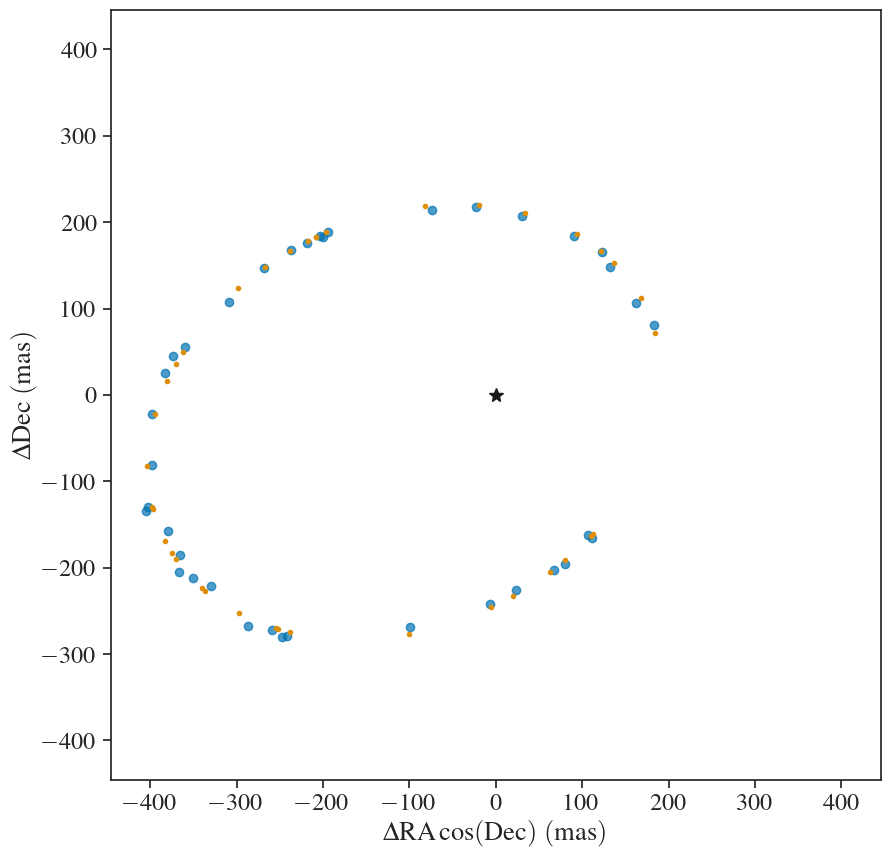

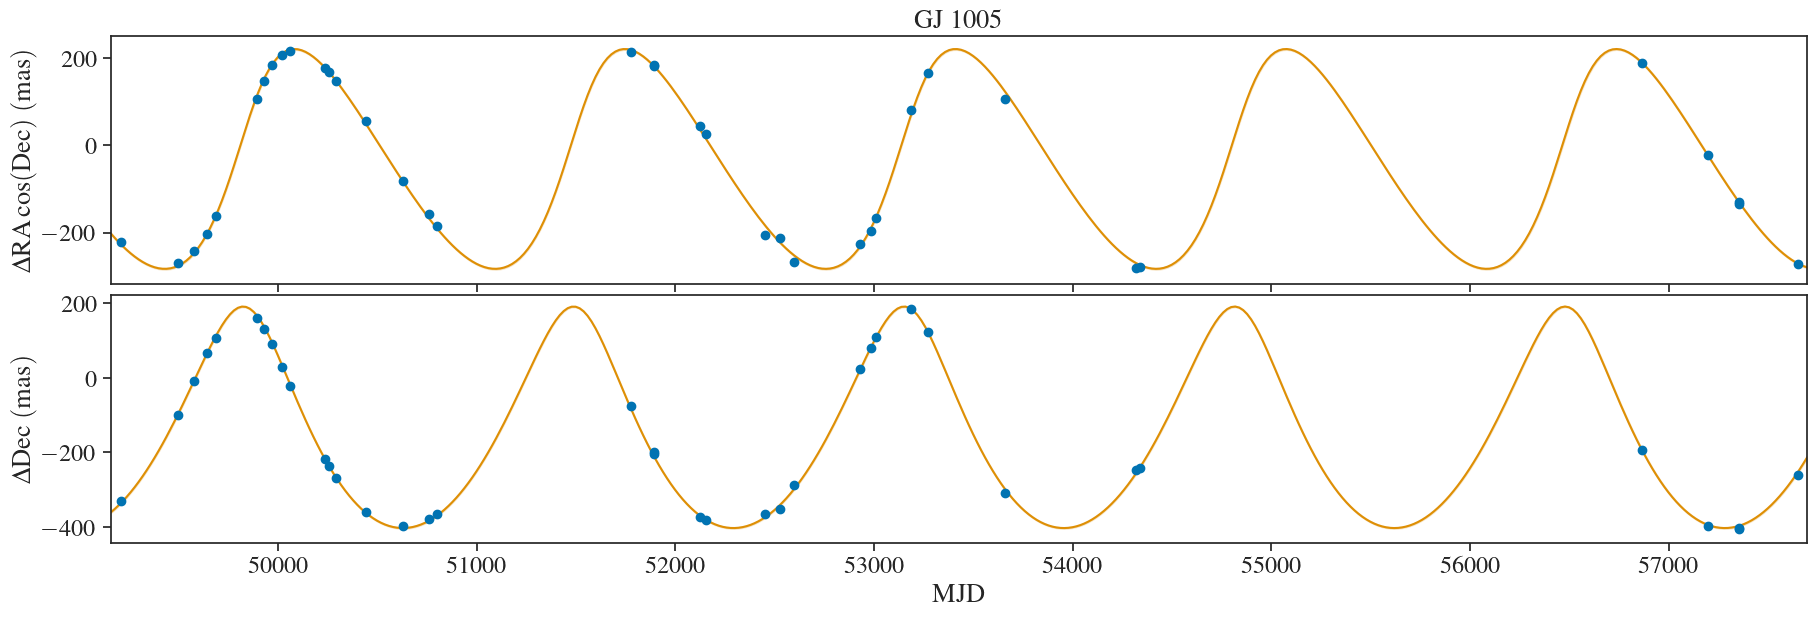

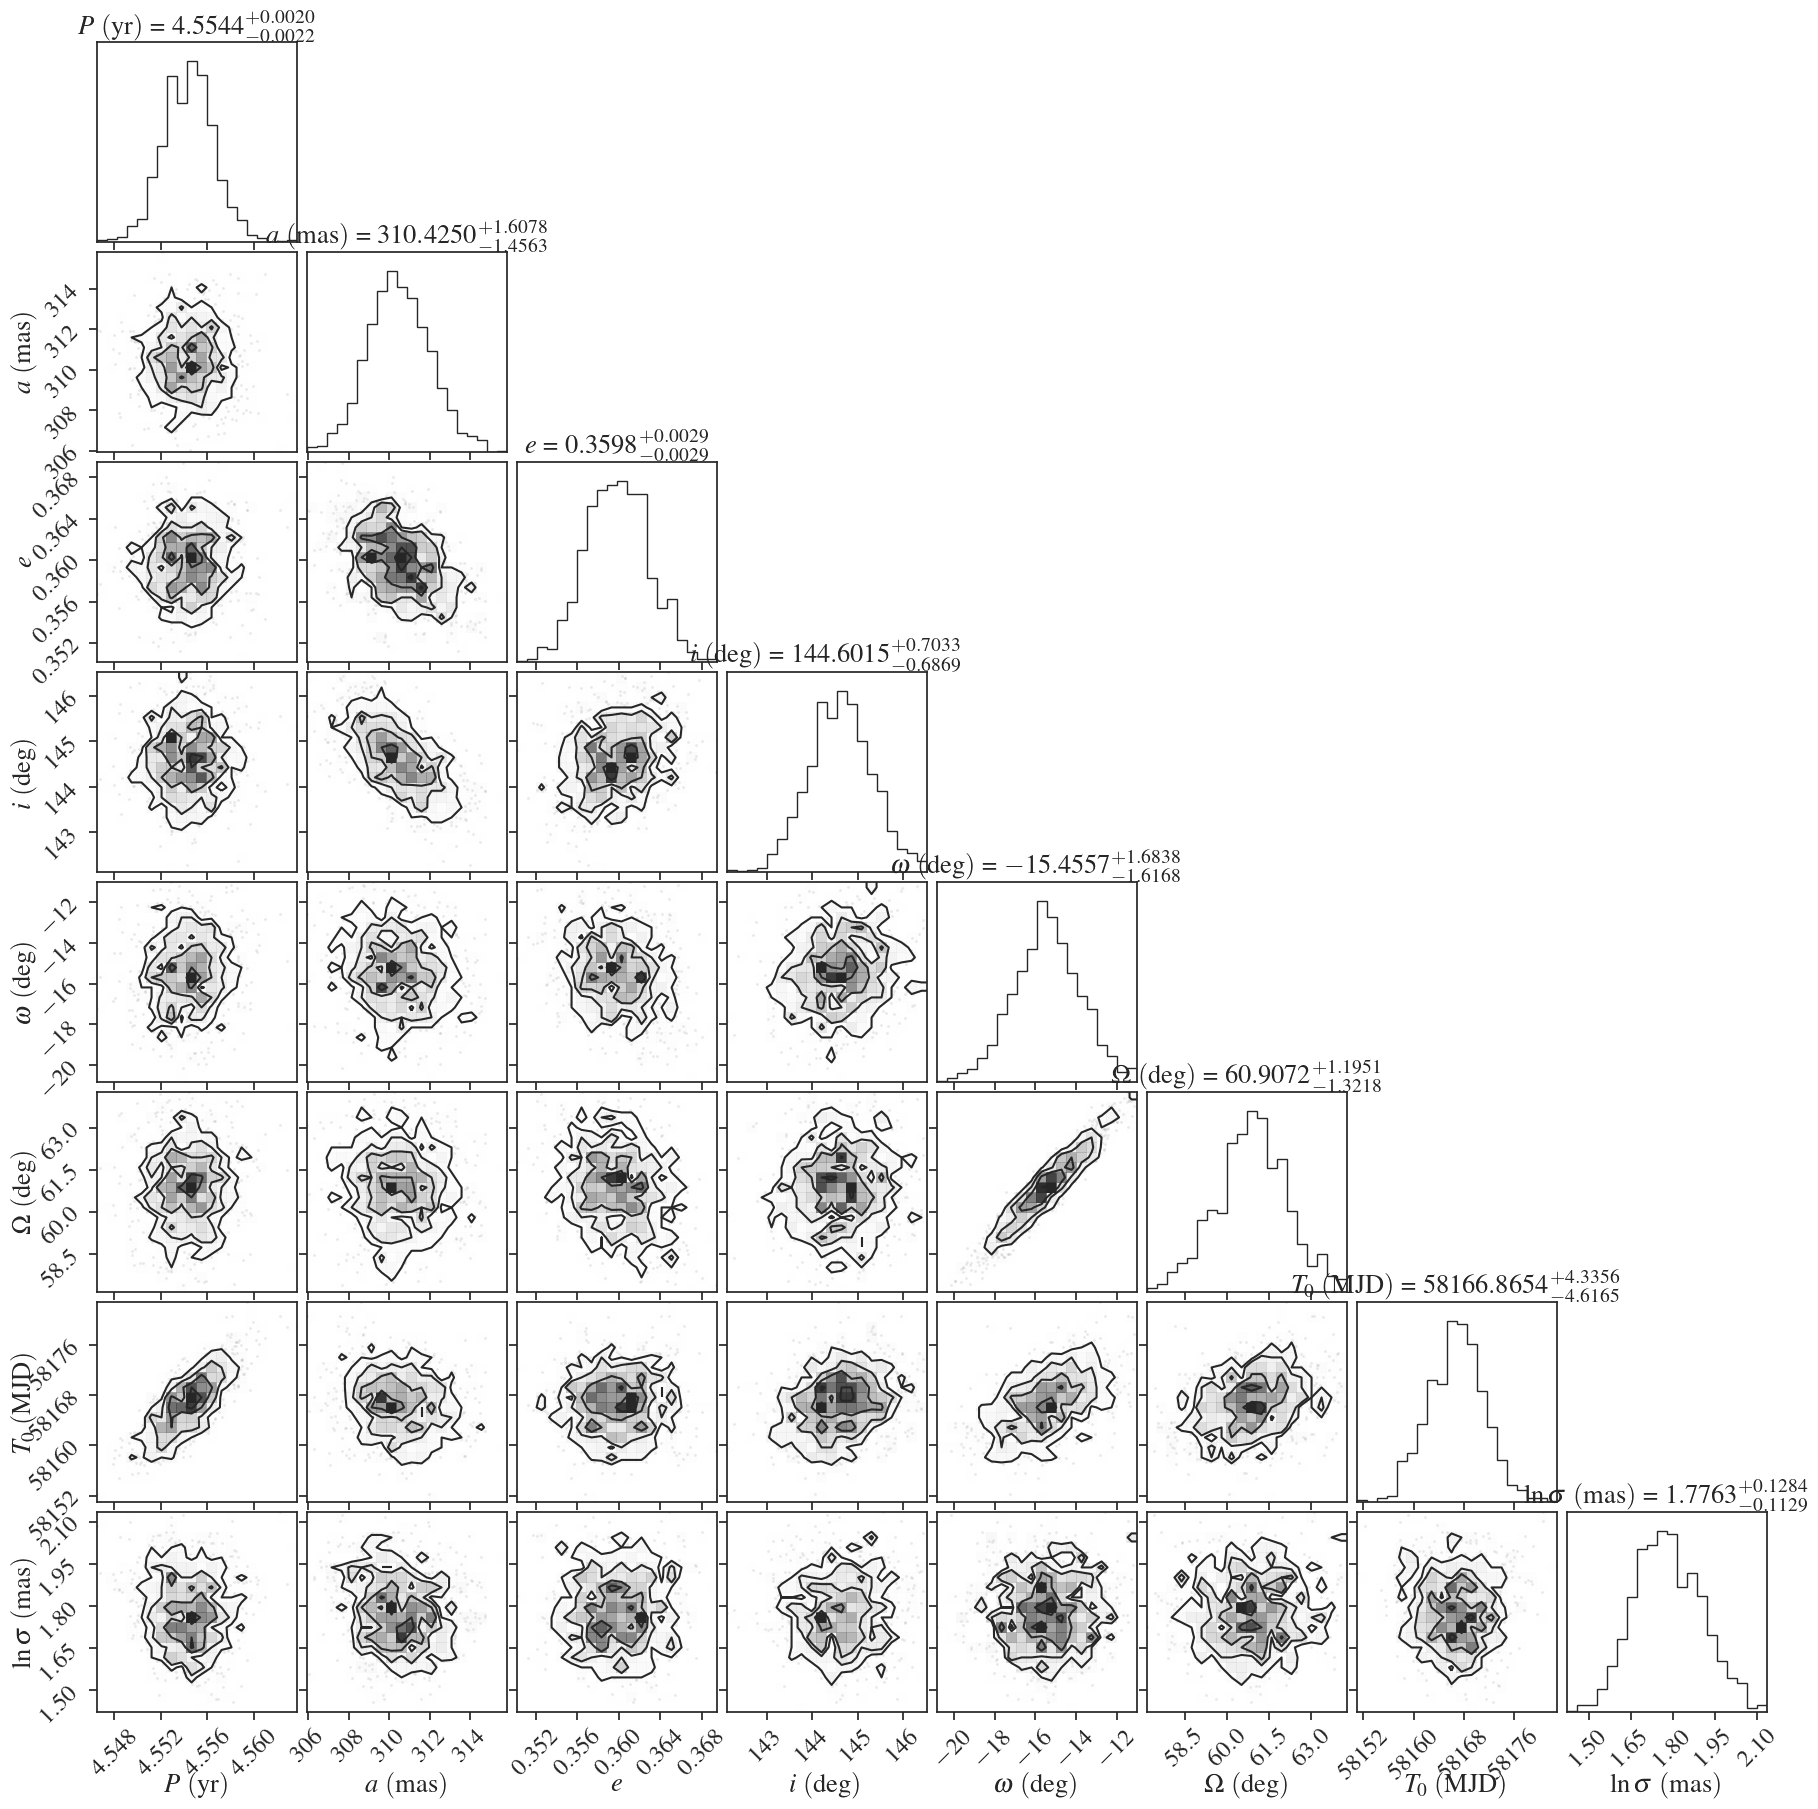

In [11]:
fit_target(targnames[0], overwrite=False)